In [1]:
import os
from model_training_utils_v2 import ST_model_hyperparam_screen, ST_model_training
os.environ['CUDA_VISIBLE_DEVICES']='1'

/root/anaconda3/envs/deepchem/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## model setup

In [2]:
# initialize parameters
task_names = ['T107', 'T108']
MT_dat_name = './data/MT_data_clean_June28.csv'
FP_type = 'Circular_2048'

params_dict = {
    "n_tasks": [1],
    
    "n_features": [2048], ## need modification given FP types
    "activation": ['relu'],
    "momentum": [.9],
    "batch_size": [128],
    "init": ['glorot_uniform'],
    "learning_rate": [0.01],
    "decay": [1e-6],
    "nb_epoch": [30],
    "dropouts": [.2, .4],
    "nb_layers": [1],
    "batchnorm": [False],
    "layer_sizes": [(1024, 512),(1024,128) ,(512, 128),(512,64),(128,64),(64,32), 
                    (1024,512,128), (512,128,64), (128,64,32)],
    "penalty": [0.1]
}

In [3]:
# initialize model setup
import random
import time
random_seed = random.randint(0,1000)
local_time = time.localtime(time.time())
log_path = './logs/'
RUN_KEY = 'ST_%d_%d_%d_%d' % (local_time.tm_year, local_time.tm_mon, 
                              local_time.tm_mday, random_seed)
os.system('mkdir %s%s' % (log_path, RUN_KEY))
print(RUN_KEY)

ST_2019_8_14_986


## hyperparameter screening

In [4]:
# hyperparam screening using deepchem
log_output = ST_model_hyperparam_screen(MT_dat_name, task_names, FP_type, params_dict, 
                                        log_path = './logs/'+RUN_KEY)

----------------------------------------------


/root/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (767) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Extracted dataset shape: (2951, 3)
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./logs/ST_2019_8_14_986/temp.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
TIMING: featurizing shard 0 took 11.429 s
TIMING: dataset construction took 11.677 s
Loading dataset from disk.
Preparing dataset for T107 of rep 0...
Computing train/valid/test indices
TIMING: dataset construction took 0.315 s
Loading dataset from disk.
TIMING: dataset construction took 0.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.140 s
Loading dataset from disk.
Hyperprameter screening ...
Fitting model 1/18
hyperparameters: {'penalty': 0.1, 'activation': 'relu', 'n_features': 2048, 'decay': 1e-06, 'batchnorm': False, 'learning_rate': 0.01, 'momentum': 0.9, 'batch_size': 128, 'nb_layers': 1, 'init': 'glorot_uniform', 'dropouts': 0.2, 'nb_epoch': 30, 'layer_sizes': (1024, 512), 'n_tasks': 1}
computed_metrics: [0.5481104503

computed_metrics: [0.6084419728173178]
Model 18/18, Metric r2_score, Validation set 17: 0.608442
	best_validation_score so far: 0.655250
computed_metrics: [0.9163785773039165]
Best hyperparameters: ((512, 128, 64), 0.1, 'relu', 2048, 1e-06, 0.01, 0.9, 128, 1, 'glorot_uniform', 30, 0.4, 1, False)
train_score: 0.916379
validation_score: 0.655250
Generate performace report ...
Preparing dataset for T107 of rep 1...
Computing train/valid/test indices
TIMING: dataset construction took 0.320 s
Loading dataset from disk.
TIMING: dataset construction took 0.149 s
Loading dataset from disk.
TIMING: dataset construction took 0.121 s
Loading dataset from disk.
Hyperprameter screening ...
Fitting model 1/18
hyperparameters: {'penalty': 0.1, 'activation': 'relu', 'n_features': 2048, 'decay': 1e-06, 'batchnorm': False, 'learning_rate': 0.01, 'momentum': 0.9, 'batch_size': 128, 'nb_layers': 1, 'init': 'glorot_uniform', 'dropouts': 0.2, 'nb_epoch': 30, 'layer_sizes': (1024, 512), 'n_tasks': 1}
compute

computed_metrics: [0.6894147493435725]
Model 18/18, Metric r2_score, Validation set 17: 0.689415
	best_validation_score so far: 0.719962
computed_metrics: [0.9520767295678436]
Best hyperparameters: ((512, 128, 64), 0.1, 'relu', 2048, 1e-06, 0.01, 0.9, 128, 1, 'glorot_uniform', 30, 0.2, 1, False)
train_score: 0.952077
validation_score: 0.719962
Generate performace report ...
Preparing dataset for T107 of rep 2...
Computing train/valid/test indices
TIMING: dataset construction took 0.293 s
Loading dataset from disk.
TIMING: dataset construction took 0.115 s
Loading dataset from disk.
TIMING: dataset construction took 0.116 s
Loading dataset from disk.
Hyperprameter screening ...
Fitting model 1/18
hyperparameters: {'penalty': 0.1, 'activation': 'relu', 'n_features': 2048, 'decay': 1e-06, 'batchnorm': False, 'learning_rate': 0.01, 'momentum': 0.9, 'batch_size': 128, 'nb_layers': 1, 'init': 'glorot_uniform', 'dropouts': 0.2, 'nb_epoch': 30, 'layer_sizes': (1024, 512), 'n_tasks': 1}
compute

computed_metrics: [0.5617374658837493]
Model 18/18, Metric r2_score, Validation set 17: 0.561737
	best_validation_score so far: 0.574066
computed_metrics: [0.8890936408066037]
Best hyperparameters: ((1024, 128), 0.1, 'relu', 2048, 1e-06, 0.01, 0.9, 128, 1, 'glorot_uniform', 30, 0.4, 1, False)
train_score: 0.889094
validation_score: 0.574066
Generate performace report ...
----------------------------------------------
Extracted dataset shape: (2063, 3)
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./logs/ST_2019_8_14_986/temp.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
TIMING: featurizing shard 0 took 8.051 s
TIMING: dataset construction took 8.207 s
Loading dataset from disk.
Preparing dataset for T108 of rep 0...
Computing train/valid/test indices
TIMING: dataset construction took 0.209 s
Loading dataset from disk.
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset 

computed_metrics: [0.5759372539391608]
Model 17/18, Metric r2_score, Validation set 16: 0.575937
	best_validation_score so far: 0.642894
Fitting model 18/18
hyperparameters: {'penalty': 0.1, 'activation': 'relu', 'n_features': 2048, 'decay': 1e-06, 'batchnorm': False, 'learning_rate': 0.01, 'momentum': 0.9, 'batch_size': 128, 'nb_layers': 1, 'init': 'glorot_uniform', 'dropouts': 0.4, 'nb_epoch': 30, 'layer_sizes': (128, 64, 32), 'n_tasks': 1}
computed_metrics: [0.6011259388892263]
Model 18/18, Metric r2_score, Validation set 17: 0.601126
	best_validation_score so far: 0.642894
computed_metrics: [0.878111896316526]
Best hyperparameters: ((1024, 128), 0.1, 'relu', 2048, 1e-06, 0.01, 0.9, 128, 1, 'glorot_uniform', 30, 0.4, 1, False)
train_score: 0.878112
validation_score: 0.642894
Generate performace report ...
Preparing dataset for T108 of rep 1...
Computing train/valid/test indices
TIMING: dataset construction took 0.234 s
Loading dataset from disk.
TIMING: dataset construction took 0.0

computed_metrics: [0.6337577807823557]
Model 17/18, Metric r2_score, Validation set 16: 0.633758
	best_validation_score so far: 0.675405
Fitting model 18/18
hyperparameters: {'penalty': 0.1, 'activation': 'relu', 'n_features': 2048, 'decay': 1e-06, 'batchnorm': False, 'learning_rate': 0.01, 'momentum': 0.9, 'batch_size': 128, 'nb_layers': 1, 'init': 'glorot_uniform', 'dropouts': 0.4, 'nb_epoch': 30, 'layer_sizes': (128, 64, 32), 'n_tasks': 1}
computed_metrics: [0.6327424936791699]
Model 18/18, Metric r2_score, Validation set 17: 0.632742
	best_validation_score so far: 0.675405
computed_metrics: [0.9318955372212835]
Best hyperparameters: ((128, 64), 0.1, 'relu', 2048, 1e-06, 0.01, 0.9, 128, 1, 'glorot_uniform', 30, 0.4, 1, False)
train_score: 0.931896
validation_score: 0.675405
Generate performace report ...
Preparing dataset for T108 of rep 2...
Computing train/valid/test indices
TIMING: dataset construction took 0.202 s
Loading dataset from disk.
TIMING: dataset construction took 0.08

computed_metrics: [0.522967609358389]
Model 17/18, Metric r2_score, Validation set 16: 0.522968
	best_validation_score so far: 0.610805
Fitting model 18/18
hyperparameters: {'penalty': 0.1, 'activation': 'relu', 'n_features': 2048, 'decay': 1e-06, 'batchnorm': False, 'learning_rate': 0.01, 'momentum': 0.9, 'batch_size': 128, 'nb_layers': 1, 'init': 'glorot_uniform', 'dropouts': 0.4, 'nb_epoch': 30, 'layer_sizes': (128, 64, 32), 'n_tasks': 1}
computed_metrics: [0.6275553205084103]
Model 18/18, Metric r2_score, Validation set 17: 0.627555
	best_validation_score so far: 0.627555
computed_metrics: [0.9142279933418767]
Best hyperparameters: ((128, 64, 32), 0.1, 'relu', 2048, 1e-06, 0.01, 0.9, 128, 1, 'glorot_uniform', 30, 0.4, 1, False)
train_score: 0.914228
validation_score: 0.627555
Generate performace report ...


In [5]:
# manually pick the training parameters, referring to hyperparam_log saved in RUN_KEY directory
best_hyperparams = {'T107': [(512,64,1), 0.4],
                    'T108': [(512,128,1), 0.2]
                   }

## model training

In [6]:
MT_dat_name = './data/MT_data_clean_June28.csv'
FP_type = 'Circular_2048'
RUN_KEY = 'ST_2019_8_14_986'

In [7]:
# model training
output_df = ST_model_training(MT_dat_name, FP_type, 
                              best_hyperparams, result_path = './logs/'+RUN_KEY)

----------------------------------------------
Extracted dataset shape: (2063, 3)
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./logs/ST_2019_8_14_986/temp.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
TIMING: featurizing shard 0 took 8.254 s
TIMING: dataset construction took 8.417 s
Loading dataset from disk.
Preparing dataset for T108 of rep 0...
Computing train/valid/test indices
TIMING: dataset construction took 0.211 s
Loading dataset from disk.
TIMING: dataset construction took 0.098 s
Loading dataset from disk.
Model training ...
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/5
1650/1650 [==============================] - 0s - loss: 4.5879     
Epoch 2/5
1650/1650 [==============================] - 0s - loss: 1.1412     
Epoch 3/5
1650/1650 [==============================] - 0s - loss: 0.7993     
Epoch 4/5
1650/1650 [==============================] - 0s - loss

/root/anaconda3/envs/deepchem/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Saving metrics ...
Preparing dataset for T108 of rep 1...
Computing train/valid/test indices
TIMING: dataset construction took 0.187 s
Loading dataset from disk.
TIMING: dataset construction took 0.103 s
Loading dataset from disk.
Model training ...
Epoch 1/5
1650/1650 [==============================] - 0s - loss: 4.3973     
Epoch 2/5
1650/1650 [==============================] - 0s - loss: 1.1658     
Epoch 3/5
1650/1650 [==============================] - 0s - loss: 0.8354     
Epoch 4/5
1650/1650 [==============================] - 0s - loss: 0.6408     
Epoch 5/5
1650/1650 [==============================] - 0s - loss: 0.5431     
Epoch 1/5
1650/1650 [==============================] - 0s - loss: 0.0624     
Epoch 2/5
1650/1650 [==============================] - 0s - loss: 0.0663     
Epoch 3/5
1650/1650 [==============================] - 0s - loss: 0.0614     
Epoch 4/5
1650/1650 [==============================] - 0s - loss: 0.0589     
Epoch 5/5
1650/1650 [===========================

In [1]:
from VISAR_model_utils_v2 import generate_performance_plot_ST
import seaborn as sns
plot_df = generate_performance_plot_ST('./logs/ST_2019_8_14_986/performance_metrics.csv')

/root/anaconda3/envs/deepchem/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


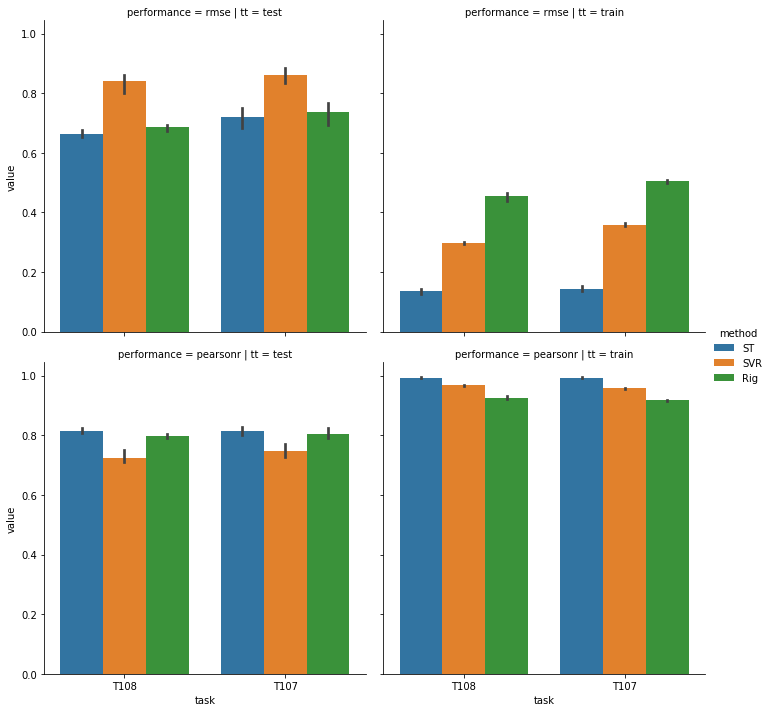

In [3]:
g = sns.catplot(x = 'task', y = 'value', hue = 'method', 
                col = 'tt', row = 'performance', 
                data = plot_df, kind = 'bar')

## process trained results for VISAR analysis

In [2]:
from VISAR_model_utils_v2 import generate_RUNKEY_dataframe_ST
RUN_KEY = 'ST_2019_8_14_986'
log_path = './logs/'
prev_model = log_path + RUN_KEY + '/T107_rep2_50.hdf5'
output_prefix = 'T107_rep2_50_'
task_list = ['T107']
add_features = None
dataset_file = log_path + RUN_KEY + '/temp.csv'
FP_type = 'Circular_2048'

In [3]:
generate_RUNKEY_dataframe_ST(prev_model, output_prefix, task_list, dataset_file, FP_type, add_features, 
                             n_layer = 1)

------------- Loading dataset --------------------


/root/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (767) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Extracted dataset shape: (2951, 3)
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./logs/ST_2019_8_14_986/temp.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
TIMING: featurizing shard 0 took 11.564 s
TIMING: dataset construction took 11.787 s
Loading dataset from disk.
------------- Loading previous trained models ------------------
Instructions for updating:
keep_dims is deprecated, use keepdims instead
------------- Prepare information for chemicals ------------------
------------- Prepare information for minibatches ------------------
------------- Prepare information for tasks ------------------
------- Generate color labels with default K of 5 --------
-------------- Saving datasets ----------------


Next:
- copy output files (including output_compound_df, output_batch_df, output_task_df) to a data directory, and clear the VISAR_webapp static directory if neccessary;
- start the app in prompt window by 'bokeh serve --show VISAR_webapp'